### Solving Poisson Equation on S^2: $\Delta u = f$


In [1]:
import my_backends 
from my_backends.ducc0_wrapper import *
import my_shcoeffs
from my_shcoeffs import SHCoeffs
## my_shcoeffs contains expand_adjoint_analysis

[Errno 2] No such file or directory: 'C:\\Users\\ifisa\\Documents\\PDPINN\\doc\\plmbar.doc'
[Errno 2] No such file or directory: 'C:\\Users\\ifisa\\Documents\\PDPINN\\doc\\plmbar_d1.doc'
[Errno 2] No such file or directory: 'C:\\Users\\ifisa\\Documents\\PDPINN\\doc\\plbar.doc'
[Errno 2] No such file or directory: 'C:\\Users\\ifisa\\Documents\\PDPINN\\doc\\plbar_d1.doc'
[Errno 2] No such file or directory: 'C:\\Users\\ifisa\\Documents\\PDPINN\\doc\\plmon.doc'
[Errno 2] No such file or directory: 'C:\\Users\\ifisa\\Documents\\PDPINN\\doc\\plmon_d1.doc'
[Errno 2] No such file or directory: 'C:\\Users\\ifisa\\Documents\\PDPINN\\doc\\plon.doc'
[Errno 2] No such file or directory: 'C:\\Users\\ifisa\\Documents\\PDPINN\\doc\\plon_d1.doc'
[Errno 2] No such file or directory: 'C:\\Users\\ifisa\\Documents\\PDPINN\\doc\\plmschmidt.doc'
[Errno 2] No such file or directory: 'C:\\Users\\ifisa\\Documents\\PDPINN\\doc\\plmschmidt_d1.doc'
[Errno 2] No such file or directory: 'C:\\Users\\ifisa\\Documents

In [2]:
import torch

N = 20
from Basis import SPHBasis
from Problem import Problem_Sphere_Poisson
from Model import Model
from Net import Sphere_Net, SPH_Sphere_Net
import seaborn as sns
import matplotlib.pyplot as plt
import math
from math import pi
from spherical_harmonics import *
from torch.distributions.uniform import Uniform
from numpy import arccos
import numpy as np

import pyshtools
from pyshtools.shio import shread
from pyshtools.expand import MakeGridDH
from pyshtools.expand import SHExpandDH
from pyshtools.spectralanalysis import spectrum

torch.manual_seed(0)
maxiter = 1000
problem = Problem_Sphere_Poisson()

In [3]:
N = 20
#             cos_azimuth = torch.linspace(-0.9999, 0.9999, N, requires_grad=False)
#             azimuth = torch.arccos(cos_azimuth)
azimuth = torch.linspace(0.0001, pi, N, requires_grad=False)
polar = torch.linspace(0, 2*pi, 2*N, requires_grad=False)

## noise
#             dpolar = 2*pi/(2*N-1)
#             dazimuth = 2.0/(N-1)
#             polar_noise = torch.distributions.Uniform(low = -dpolar/2, high = dpolar/2).sample(sample_shape=torch.Size(polar.shape))
#             azimuth_noise = torch.distributions.Uniform(low = -dazimuth/2, high = dazimuth/2).sample(sample_shape=torch.Size(azimuth.shape))            
#             azimuth, polar = azimuth + azimuth_noise, polar + polar_noise

azimuth, polar = torch.meshgrid(azimuth, polar)
location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
location.shape

torch.Size([800, 2])

pde: tensor(84.2727, grad_fn=<MseLossBackward>)
bc: tensor(0.2395, grad_fn=<MseLossBackward>)
init: tensor(0.)
iteration 0: loss = 84.51215362548828


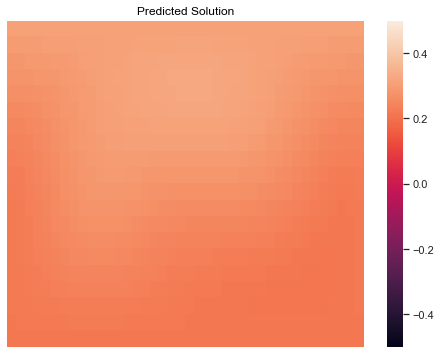

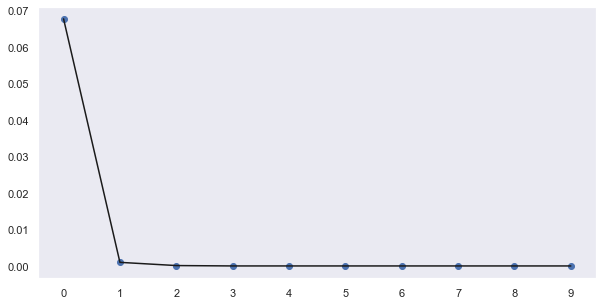

pde: tensor(83.8914, grad_fn=<MseLossBackward>)
bc: tensor(0.1073, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(83.1619, grad_fn=<MseLossBackward>)
bc: tensor(0.0341, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(81.5667, grad_fn=<MseLossBackward>)
bc: tensor(0.0132, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(78.3091, grad_fn=<MseLossBackward>)
bc: tensor(0.0375, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(72.3300, grad_fn=<MseLossBackward>)
bc: tensor(0.1643, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(63.4635, grad_fn=<MseLossBackward>)
bc: tensor(0.1679, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(58.6663, grad_fn=<MseLossBackward>)
bc: tensor(0.0146, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(63.1875, grad_fn=<MseLossBackward>)
bc: tensor(0.5369, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(61.0198, grad_fn=<MseLossBackward>)
bc: tensor(0.4087, grad_fn=<MseLossBackward>)
init: tensor(0.)
p

pde: tensor(1.5627, grad_fn=<MseLossBackward>)
bc: tensor(0.0044, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(1.5395, grad_fn=<MseLossBackward>)
bc: tensor(0.0042, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(1.5138, grad_fn=<MseLossBackward>)
bc: tensor(0.0032, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(1.4854, grad_fn=<MseLossBackward>)
bc: tensor(0.0014, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(1.4572, grad_fn=<MseLossBackward>)
bc: tensor(0.0012, grad_fn=<MseLossBackward>)
init: tensor(0.)
iteration 80: loss = 1.4584084749221802
pde: tensor(1.4293, grad_fn=<MseLossBackward>)
bc: tensor(0.0036, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(1.4025, grad_fn=<MseLossBackward>)
bc: tensor(0.0069, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(1.3803, grad_fn=<MseLossBackward>)
bc: tensor(0.0063, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(1.3555, grad_fn=<MseLossBackward>)
bc: tensor(0.0034, grad_fn=<MseLo

pde: tensor(0.3349, grad_fn=<MseLossBackward>)
bc: tensor(0.0002, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.3248, grad_fn=<MseLossBackward>)
bc: tensor(0.0002, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.3147, grad_fn=<MseLossBackward>)
bc: tensor(0.0002, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.3047, grad_fn=<MseLossBackward>)
bc: tensor(0.0002, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.2948, grad_fn=<MseLossBackward>)
bc: tensor(0.0001, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.2849, grad_fn=<MseLossBackward>)
bc: tensor(0.0002, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.2753, grad_fn=<MseLossBackward>)
bc: tensor(0.0001, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.2656, grad_fn=<MseLossBackward>)
bc: tensor(0.0001, grad_fn=<MseLossBackward>)
init: tensor(0.)
iteration 160: loss = 0.2657207250595093
pde: tensor(0.2561, grad_fn=<MseLossBackward>)
bc: tensor(0.0001, grad_fn=<MseL

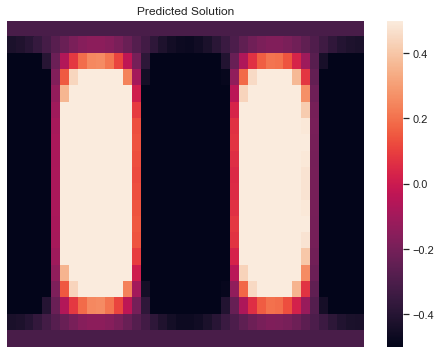

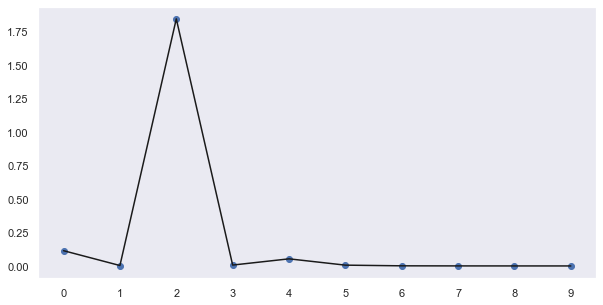

pde: tensor(0.1031, grad_fn=<MseLossBackward>)
bc: tensor(0.0169, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0465, grad_fn=<MseLossBackward>)
bc: tensor(0.0019, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.1096, grad_fn=<MseLossBackward>)
bc: tensor(0.0254, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0743, grad_fn=<MseLossBackward>)
bc: tensor(0.0096, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0492, grad_fn=<MseLossBackward>)
bc: tensor(0.0038, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0859, grad_fn=<MseLossBackward>)
bc: tensor(0.0209, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0564, grad_fn=<MseLossBackward>)
bc: tensor(0.0028, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0510, grad_fn=<MseLossBackward>)
bc: tensor(0.0071, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0616, grad_fn=<MseLossBackward>)
bc: tensor(0.0132, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tenso

pde: tensor(0.0091, grad_fn=<MseLossBackward>)
bc: tensor(2.7887e-05, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0090, grad_fn=<MseLossBackward>)
bc: tensor(6.5781e-08, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0089, grad_fn=<MseLossBackward>)
bc: tensor(5.6843e-06, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0088, grad_fn=<MseLossBackward>)
bc: tensor(2.0833e-05, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0087, grad_fn=<MseLossBackward>)
bc: tensor(7.7640e-07, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0086, grad_fn=<MseLossBackward>)
bc: tensor(8.1834e-07, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0086, grad_fn=<MseLossBackward>)
bc: tensor(1.5911e-05, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0085, grad_fn=<MseLossBackward>)
bc: tensor(2.0930e-06, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0084, grad_fn=<MseLossBackward>)
bc: tensor(1.0547e-08, grad_fn=<MseLossBa

pde: tensor(0.0084, grad_fn=<MseLossBackward>)
bc: tensor(1.5204e-06, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0103, grad_fn=<MseLossBackward>)
bc: tensor(2.6836e-06, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0134, grad_fn=<MseLossBackward>)
bc: tensor(6.5907e-06, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0189, grad_fn=<MseLossBackward>)
bc: tensor(8.2706e-06, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0284, grad_fn=<MseLossBackward>)
bc: tensor(1.7658e-05, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0446, grad_fn=<MseLossBackward>)
bc: tensor(2.6125e-05, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0694, grad_fn=<MseLossBackward>)
bc: tensor(4.2928e-05, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.1021, grad_fn=<MseLossBackward>)
bc: tensor(3.1957e-05, grad_fn=<MseLossBackward>)
init: tensor(0.)
iteration 350: loss = 0.1021035835146904
pde: tensor(0.1322, grad_fn=<MseLossBackward>)


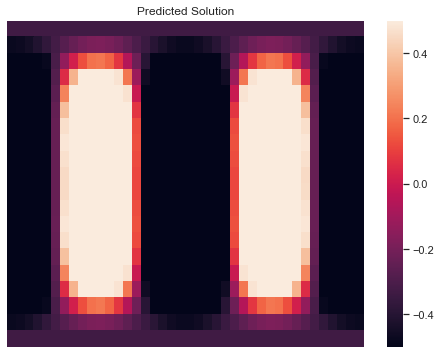

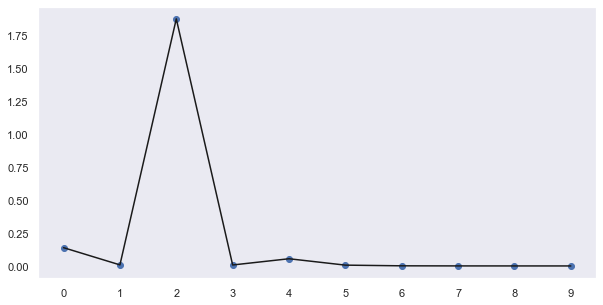

pde: tensor(0.0044, grad_fn=<MseLossBackward>)
bc: tensor(2.3190e-06, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0045, grad_fn=<MseLossBackward>)
bc: tensor(6.5318e-05, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0044, grad_fn=<MseLossBackward>)
bc: tensor(0.0001, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0043, grad_fn=<MseLossBackward>)
bc: tensor(0.0001, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0044, grad_fn=<MseLossBackward>)
bc: tensor(5.3693e-05, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0045, grad_fn=<MseLossBackward>)
bc: tensor(1.2686e-05, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0045, grad_fn=<MseLossBackward>)
bc: tensor(8.0684e-07, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0042, grad_fn=<MseLossBackward>)
bc: tensor(3.4750e-09, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0041, grad_fn=<MseLossBackward>)
bc: tensor(4.6577e-09, grad_fn=<MseLossBackward>)

init: tensor(0.)
pde: tensor(0.0191, grad_fn=<MseLossBackward>)
bc: tensor(0.0029, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0061, grad_fn=<MseLossBackward>)
bc: tensor(0.0001, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0068, grad_fn=<MseLossBackward>)
bc: tensor(0.0009, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0160, grad_fn=<MseLossBackward>)
bc: tensor(0.0027, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0145, grad_fn=<MseLossBackward>)
bc: tensor(0.0016, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0050, grad_fn=<MseLossBackward>)
bc: tensor(0.0001, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0061, grad_fn=<MseLossBackward>)
bc: tensor(0.0005, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0125, grad_fn=<MseLossBackward>)
bc: tensor(0.0016, grad_fn=<MseLossBackward>)
init: tensor(0.)
iteration 480: loss = 0.014117948710918427
pde: tensor(0.0103, grad_fn=<MseLossBackward>)
bc: tensor(0.

pde: tensor(0.0027, grad_fn=<MseLossBackward>)
bc: tensor(3.4364e-07, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0027, grad_fn=<MseLossBackward>)
bc: tensor(6.2532e-07, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0027, grad_fn=<MseLossBackward>)
bc: tensor(2.3480e-06, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0027, grad_fn=<MseLossBackward>)
bc: tensor(7.5372e-06, grad_fn=<MseLossBackward>)
init: tensor(0.)
iteration 550: loss = 0.002707512816414237
pde: tensor(0.0027, grad_fn=<MseLossBackward>)
bc: tensor(9.0599e-06, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0027, grad_fn=<MseLossBackward>)
bc: tensor(1.1440e-05, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0027, grad_fn=<MseLossBackward>)
bc: tensor(8.0381e-06, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0027, grad_fn=<MseLossBackward>)
bc: tensor(7.7424e-06, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0027, grad_fn=<MseLossBackward>

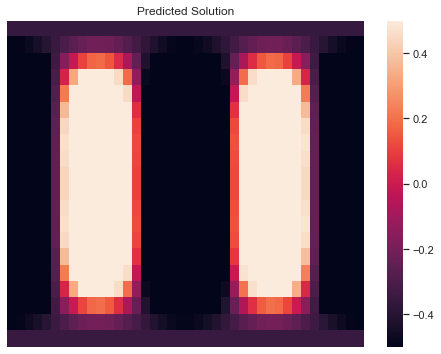

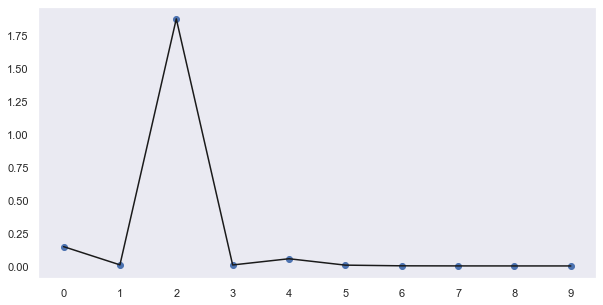

pde: tensor(0.0108, grad_fn=<MseLossBackward>)
bc: tensor(0.0003, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0109, grad_fn=<MseLossBackward>)
bc: tensor(0.0002, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0053, grad_fn=<MseLossBackward>)
bc: tensor(7.9622e-06, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0091, grad_fn=<MseLossBackward>)
bc: tensor(0.0005, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0094, grad_fn=<MseLossBackward>)
bc: tensor(0.0006, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0036, grad_fn=<MseLossBackward>)
bc: tensor(0.0001, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0067, grad_fn=<MseLossBackward>)
bc: tensor(6.3013e-05, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0087, grad_fn=<MseLossBackward>)
bc: tensor(0.0002, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0044, grad_fn=<MseLossBackward>)
bc: tensor(8.6382e-05, grad_fn=<MseLossBackward>)
init: tensor(0.

pde: tensor(0.0025, grad_fn=<MseLossBackward>)
bc: tensor(0.0001, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0027, grad_fn=<MseLossBackward>)
bc: tensor(0.0001, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0030, grad_fn=<MseLossBackward>)
bc: tensor(0.0002, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0034, grad_fn=<MseLossBackward>)
bc: tensor(0.0004, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0040, grad_fn=<MseLossBackward>)
bc: tensor(0.0007, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0050, grad_fn=<MseLossBackward>)
bc: tensor(0.0011, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0067, grad_fn=<MseLossBackward>)
bc: tensor(0.0019, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0101, grad_fn=<MseLossBackward>)
bc: tensor(0.0031, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0155, grad_fn=<MseLossBackward>)
bc: tensor(0.0051, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tenso

pde: tensor(0.0022, grad_fn=<MseLossBackward>)
bc: tensor(4.2406e-06, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0023, grad_fn=<MseLossBackward>)
bc: tensor(7.0514e-06, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0024, grad_fn=<MseLossBackward>)
bc: tensor(1.1428e-05, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0023, grad_fn=<MseLossBackward>)
bc: tensor(5.8559e-06, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0022, grad_fn=<MseLossBackward>)
bc: tensor(9.2881e-07, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0022, grad_fn=<MseLossBackward>)
bc: tensor(3.1231e-06, grad_fn=<MseLossBackward>)
init: tensor(0.)
iteration 750: loss = 0.0022079525515437126
pde: tensor(0.0023, grad_fn=<MseLossBackward>)
bc: tensor(1.0138e-05, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0023, grad_fn=<MseLossBackward>)
bc: tensor(1.0449e-05, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0021, grad_fn=<MseLossBackward

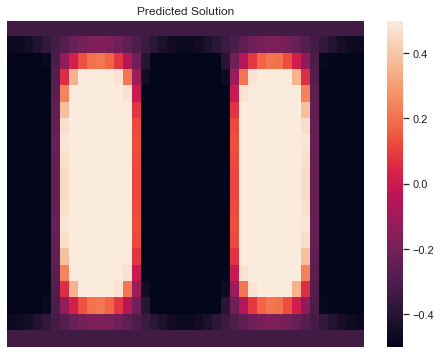

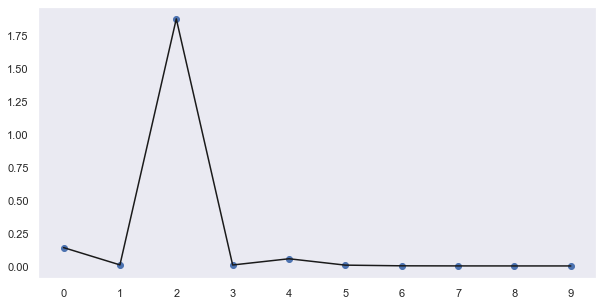

pde: tensor(0.0019, grad_fn=<MseLossBackward>)
bc: tensor(2.2324e-06, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0020, grad_fn=<MseLossBackward>)
bc: tensor(1.0880e-06, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0021, grad_fn=<MseLossBackward>)
bc: tensor(1.7998e-06, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0022, grad_fn=<MseLossBackward>)
bc: tensor(7.9319e-07, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0025, grad_fn=<MseLossBackward>)
bc: tensor(2.1240e-06, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0030, grad_fn=<MseLossBackward>)
bc: tensor(1.8745e-06, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0037, grad_fn=<MseLossBackward>)
bc: tensor(4.3795e-06, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0049, grad_fn=<MseLossBackward>)
bc: tensor(5.5873e-06, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0070, grad_fn=<MseLossBackward>)
bc: tensor(1.1557e-05, grad_fn=<MseLossBa

pde: tensor(0.0020, grad_fn=<MseLossBackward>)
bc: tensor(6.8531e-08, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0020, grad_fn=<MseLossBackward>)
bc: tensor(1.9984e-06, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0019, grad_fn=<MseLossBackward>)
bc: tensor(7.8620e-07, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0017, grad_fn=<MseLossBackward>)
bc: tensor(6.0013e-10, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0018, grad_fn=<MseLossBackward>)
bc: tensor(1.4992e-06, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0019, grad_fn=<MseLossBackward>)
bc: tensor(9.7612e-06, grad_fn=<MseLossBackward>)
init: tensor(0.)
iteration 880: loss = 0.0018711760640144348
pde: tensor(0.0019, grad_fn=<MseLossBackward>)
bc: tensor(1.3572e-05, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0018, grad_fn=<MseLossBackward>)
bc: tensor(1.5423e-05, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0017, grad_fn=<MseLossBackward

pde: tensor(0.0041, grad_fn=<MseLossBackward>)
bc: tensor(8.0716e-06, grad_fn=<MseLossBackward>)
init: tensor(0.)
iteration 950: loss = 0.004146288149058819
pde: tensor(0.0078, grad_fn=<MseLossBackward>)
bc: tensor(0.0002, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0181, grad_fn=<MseLossBackward>)
bc: tensor(0.0004, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0146, grad_fn=<MseLossBackward>)
bc: tensor(0.0005, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0047, grad_fn=<MseLossBackward>)
bc: tensor(0.0003, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0069, grad_fn=<MseLossBackward>)
bc: tensor(0.0001, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0127, grad_fn=<MseLossBackward>)
bc: tensor(1.8400e-06, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0087, grad_fn=<MseLossBackward>)
bc: tensor(0.0002, grad_fn=<MseLossBackward>)
init: tensor(0.)
pde: tensor(0.0038, grad_fn=<MseLossBackward>)
bc: tensor(0.0006, gra

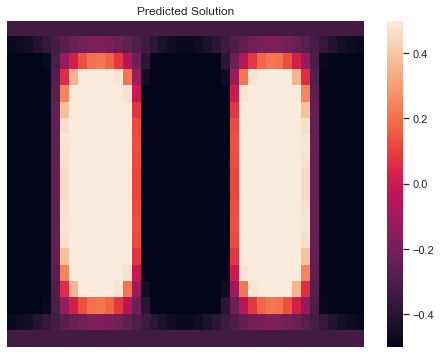

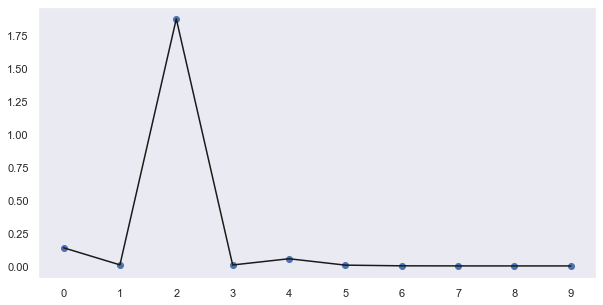

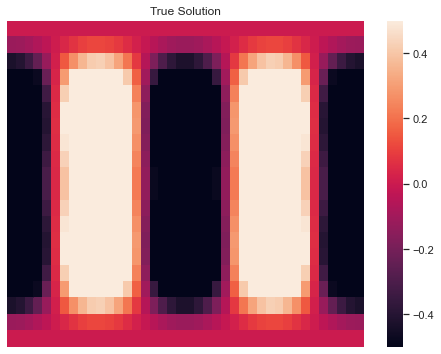

In [4]:

def construct_model(net):
    class Poisson1dModel(Model):
        def add_loss_history(self):
            self.loss_history.append([self.bc_loss, self.pde_loss, self.predict_error_value])

        def __init__(self):
            super().__init__(problem=problem, net=net, maxiter=maxiter)

        def inner_sample(self, N=N):
#             N = 25
#             cos_azimuth = torch.linspace(-0.9999, 0.9999, N, requires_grad=False)
#             azimuth = torch.arccos(cos_azimuth)
            azimuth = torch.linspace(0.0001, pi, N, requires_grad=False)
            polar = torch.linspace(0, 2*pi, 2*N, requires_grad=False)
            
            ## noise
#             dpolar = 2*pi/(2*N-1)
#             dazimuth = 2.0/(N-1)
#             polar_noise = torch.distributions.Uniform(low = -dpolar/2, high = dpolar/2).sample(sample_shape=torch.Size(polar.shape))
#             azimuth_noise = torch.distributions.Uniform(low = -dazimuth/2, high = dazimuth/2).sample(sample_shape=torch.Size(azimuth.shape))            
#             azimuth, polar = azimuth + azimuth_noise, polar + polar_noise

            azimuth, polar = torch.meshgrid(azimuth, polar)
#             print('azimuth', azimuth.size())
#             print('polar', polar.size())
            location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
#             print('location', location.size())
            return location
#             x = torch.randn(num, 3)
#             x = x / (torch.norm(x, dim=1).reshape((-1, 1)))
        
#             polar = torch.atan(x[:, :1] / x[:, 1:2]) + math.pi / 2
#             polar[:num // 2, 0] = polar[:num // 2, 0] + math.pi
#             azimuth = torch.acos(x[:, 2:3])
            
#             ## noise
#             dpolar = 2 * pi/(num-1) 
#             polar_noise = polar + torch.distributions.Uniform(low = -dpolar/2, high = dpolar/2).sample(sample_shape=torch.Size(polar.shape))
            
#             dazimuth = pi/(num-1) 
#             azimuth_noise = azimuth + torch.distributions.Uniform(low = -dazimuth/2, high = dazimuth/2).sample(sample_shape=torch.Size(polar.shape))            
            
#             x = torch.cat([azimuth_noise, polar_noise], dim=1)
#             return x

        def bc_sample(self):
            return torch.tensor([[1., 1.]])

        def init_sample(self):
            pass

        def plot(self, net):
            azimuth = torch.linspace(0, math.pi, N, requires_grad=False)
            polar = torch.linspace(0, 2 * math.pi, 2*N, requires_grad=False)
            azimuth, polar = torch.meshgrid(azimuth, polar)
            location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
            value = net(location)
            
            value = value.reshape((N, 2*N))
            
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
            sns.set()
            sns.heatmap(value.detach().numpy(), ax=ax, vmin=-0.5, vmax=0.5, cbar=True)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("Predicted Solution")
            plt.show()
            
            self.spherical_harmonic_transform(net)
        
        def spherical_harmonic_transform(self, net):
            azimuth = torch.linspace(0, math.pi, N, requires_grad=False)
            polar = torch.linspace(0, 2 * math.pi, 2*N, requires_grad=False)
            azimuth, polar = torch.meshgrid(azimuth, polar)
            location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
            function_grid = net(location)
            function_grid = function_grid.reshape((N, 2*N))
            
            coefficients = SHExpandDH(function_grid.detach().numpy(), sampling=2)
            nl = coefficients.shape[1]
            ls = np.arange(nl)[:10]

            power_per_l = spectrum(coefficients)[:10]
            fig, ax = plt.subplots(1, 1, figsize=(len(ls), 5))
            ax.plot(ls, power_per_l, 'bo')
            ax.plot(ls, power_per_l, 'k-')
            plt.xticks(range(len(ls)))
            # ax.set_yscale('log')
            # ax.set_xscale('log')
            ax.grid()
            plt.show()
            
        
        def plot_true(self):
            azimuth = torch.linspace(0, math.pi, N, requires_grad=False)
            polar = torch.linspace(0, 2 * math.pi, 2*N, requires_grad=False)
            azimuth, polar = torch.meshgrid(azimuth, polar)
            location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
            value = true_solution(location[:, 0:1], location[:, 1:])
            
            value = value.reshape((N, 2*N))
            
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
            sns.set()
            sns.heatmap(value.detach().numpy(), ax=ax, vmin=-0.5, vmax=0.5, cbar=True)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("True Solution")
            plt.show()
            
        def post_process(self, ax=None):
            if ax is None:
                for losses in self.loss_history:
                    for i in range(3):
                        losses[i].detach().numpy()
                plt.plot(self.loss_history)
                plt.yscale('log')
                plt.legend(('BC loss', 'pde loss', 'predict error'))
                plt.show()
            else:
                for losses in self.loss_history:
                    for i in range(3):
                        losses[i].detach().numpy()
                ax.plot(self.loss_history)
                ax.set_yscale('log')
                ax.set_ylim(1e-4, 100)
                ax.legend(('BC loss', 'pde loss', 'predict error'))

        def predict_error(self):
            coor = self.inner_sample()
            true = self.problem.ground_truth(coor)
            predict = self.net(coor)
            predict_error = self.pde_loss_f(true, predict)
            return predict_error

        def train(self, ax100=None):
            problem = self.problem
            net = self.net
            opt = self.opt
            maxiter = self.maxiter

            for iter in range(maxiter):
                net.zero_grad()

                coor_inner = self.inner_sample().detach().requires_grad_(True)
                infer_value_inner = net(coor_inner)
                truth_inner, predict_inner = problem.pde(coor_inner, infer_value_inner)
                self.pde_loss = self.pde_loss_f(predict_inner, truth_inner)

                bc_samples = self.bc_sample()
                if bc_samples is None:
                    self.bc_loss = torch.tensor(0.)
                else:
                    coor_bc = bc_samples.detach().requires_grad_(True)
                    infer_value_bc = net(coor_bc)
                    truth_bc, predict_bc = problem.bound_condition(coor_bc, infer_value_bc)
                    self.bc_loss = self.bc_loss_f(predict_bc, truth_bc)

                init_samples = self.init_sample()
                if init_samples is None:
                    self.init_loss = torch.tensor(0.)
                else:
                    coor_init = init_samples.detach().requires_grad_(True)
                    infer_value_init = net(coor_init)
                    truth_init, predict_init = problem.bound_condition(coor_init, infer_value_init)
                    self.init_loss = self.bc_loss_f(predict_init, truth_init)
                self.predict_error_value = self.predict_error()
                self.total_loss = self.pde_loss + self.bc_loss + self.init_loss
                print("pde: "+ str(self.pde_loss))
                print("bc: "+ str(self.bc_loss))
                print("init: "+ str(self.init_loss))
                self.add_loss_history()
                self.total_loss.backward()

                opt.step()
                opt.zero_grad()
                
                if iter % (maxiter // 100) == 0:
                    print("iteration {}: loss = {}".format(iter, self.total_loss))
                        
                if iter % int(maxiter / 5) == 0:
                    self.plot(net)
                
            self.plot(net)
            self.plot_true()
#             self.post_process()

    return Poisson1dModel()

model = construct_model(Sphere_Net([3, 50, 50, 50, 16, 1]))
model.train()
